<a href="https://colab.research.google.com/github/mxn170019/Skin-Cancer-Identification-Tensorflow-CNN/blob/master/Skin_cancer_mnist_tf_fulldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Lab 1: Skin Cancer MNIST
=========================
![skin-cancer-cover](imgs/skin-mnist-cover.png "Examples of Skin Lesions")

## The Problem

From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]

> Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.



## Imports

Let's import Tensorflow now.  It is helpful after importing Tensorflow to check the version of the library installed since the API's are changing so quickly.  Several machines are now starting to use Tensorflow 2.0rc which has a very different interface from v1.* as well.  In preparation for TF 2.0, this tutorial will use the Eager Execution API, which is used by default in future version.

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.14.0
Is GPU available: True
Is Eager Execution enabled?: True


In [2]:
import os
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import shutil
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Dropout
from tensorflow.keras import backend as K

Using TensorFlow backend.


### Dataset- About HAM10000

In this exercise we will be using  HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."[Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) This dataset has ~10K dermatoscopic images that have been reformatted to be similar smaller like the famous Handwritten Digit or MNIST dataset (64 x 64 images centered on the subject).  This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

### Load the dataset

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mxn170019","key":"3a67e29bb92b34ac3c0d8fadd0dfb4bc"}'}

In [4]:
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets list -s skin
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 

with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
    
!rm /content/skin-cancer-mnist-ham10000.zip

-rw-r--r-- 1 root root 65 Sep 24 05:47 kaggle.json
100% 2.61G/2.62G [00:47<00:00, 67.0MB/s]
100% 2.62G/2.62G [00:47<00:00, 59.4MB/s]


In [0]:
with zipfile.ZipFile('/content/HAM10000_images_part_1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000_images_part_1')
!rm /content/HAM10000_images_part_1.zip

with zipfile.ZipFile('/content/HAM10000_images_part_2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000_images_part_2')
!rm /content/HAM10000_images_part_2.zip

We will load both the included meta file as well as the image data (provided conveniently as a CSV file with one row per image.

In [6]:
data_dir = '/content/'
os.listdir(data_dir)

['.config',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_1',
 'kaggle.json',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_RGB.csv',
 'sample_data']

In [0]:
# create a path to 'data_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(data_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(data_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
non_nv = os.path.join(train_dir, 'non-nv')
os.mkdir(non_nv)

# create new folders inside valid_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
non_nv = os.path.join(val_dir, 'non-nv')
os.mkdir(non_nv)


### Inspect the meta data

- Lesions with multiple images

For each image we have a `lesion_id` as well as a an `image_id`.  We should note that there are in fact multiple images for the same lesion which we need to be mindful of as we construct our training and testing splits.  While this has been accounted for in the pre-made splits, it is a potential leakage between the training and validation splits if the same patients were in both populations.

In [8]:
meta_df = pd.read_csv(os.path.join(data_dir,'HAM10000_metadata.csv'))
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Below, we count the occurrences of a lesion_id, accumulate the lesions ids with more than 1 image and then add a flag to our original meta_df to indicate whether the lesion has more than one image in the dataset.

In [0]:
def pretty_count_print(series):
    display(pd.DataFrame(series.value_counts()))

### Classes

The dataset contains 7 classes of lesions, a mixture of both benign and cancerous types.  The dataset is overweight to benign melanocytic nevi, a harmless mole.  However, there are over 2,000 examples of cancerous lesions to detect in this dataset.


| Id |Abbr | Name |
|---|---|---|
| 4 | nv | Melanocytic nevi |
| 6 | mel | Melanoma |
| 2 | bkl | Benign keratosis-like lesion |
| 1 | bcc | Basal cell carcinoma |
| 0 | akiec |  Actinic keratoses |
| 5 | vasc | Vascular lesions (angiomas, etc.) |
| 3 | df | Dermatofibroma |

In [10]:
class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
pretty_count_print(meta_df['dx'])

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Let's gather examples of each class to inspect visually.

In [0]:
# example_list = {}
# class_names = ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']
# for cls in range(7):
#     example_list[class_names[cls]] = np.nonzero(train_data['labels'] == cls)[0][0]
# display(example_list)

In [0]:
# fig, ax = plt.subplots(4,2, figsize=(20,20))
# fig.delaxes(ax[3,1]) # Delete the extra plot
# for i, (key, value) in enumerate(example_list.items()):
#     ax[i//2,i%2].title.set_text(key)
#     ax[i//2,i%2].imshow(train_data['images'][value])

In [0]:
#Change the labels from multiclass ro binary class
meta_df['label']= meta_df.dx.map({'akiec':'non-nv','bcc':'non-nv','bkl':'non-nv','df':'non-nv','mel':'non-nv','nv':'nv','vasc':'non-nv'})

###Create a stratified val set


In [14]:
lesion_image_counts = pd.DataFrame( meta_df.groupby('lesion_id')['image_id'].count())
dupe_lesion_ids = list(lesion_image_counts[lesion_image_counts['image_id'] > 1].index.values)
meta_df['dupe'] = meta_df.apply(lambda row: row['lesion_id'] in dupe_lesion_ids, axis=1)
pretty_count_print(meta_df['dupe'])

,dupe
False,5514
True,4501


In [15]:
# now we filter out images that don't have duplicates
unique_lension_df = meta_df[meta_df.dupe == False]
unique_lension_df.shape

(5514, 9)

In [16]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = unique_lension_df['dx']

_, df_val = train_test_split(unique_lension_df, test_size=0.15, random_state=0, stratify=y)

df_val.dx.value_counts()

nv       663
bkl       66
mel       34
bcc       26
akiec     23
vasc      10
df         6
Name: dx, dtype: int64

###Create a train set that excludes images that are in the val set¶



In [17]:
# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


# apply the function to make new column
meta_df['train_or_val'] = meta_df['image_id'].apply(identify_val_rows)
   
# filter out train rows
df_train = meta_df[meta_df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


9187
828


###Transfer the images into directories

In [0]:
# Set the image_id as the index in df_data
meta_df.set_index('image_id', inplace=True)

In [19]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


folder_1_dir = os.path.join(data_dir,'HAM10000_images_part_1')
folder_2_dir = os.path.join(data_dir,'HAM10000_images_part_2')

folder_1 = os.listdir(folder_1_dir)
folder_2 = os.listdir(folder_2_dir)



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = meta_df.loc[image,'label']
    
    if fname in folder_1:
        src = os.path.join(folder_1_dir, fname)
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(folder_2_dir, fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = meta_df.loc[image,'label']
    
    if fname in folder_1:
        src = os.path.join(folder_1_dir, fname)
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(folder_2_dir, fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

print(len(os.listdir('train_dir/nv')))
print(len(os.listdir('train_dir/non-nv')))
print(len(os.listdir('val_dir/nv')))
print(len(os.listdir('val_dir/non-nv')))

6042
3145
663
165


### Prepare the data

### Generate the augmented images and add them to the training folders

In [20]:
# note that we are not augmenting class 'nv'
class_list = ['non-nv']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    
    aug_dir = os.path.join(data_dir, 'aug_dir')
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('train_dir/' + img_class)
    
    
# Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

# point to a dir containing the images and not to the images themselves
path = aug_dir
save_path = 'train_dir/' + img_class

# Create a data generator
datagen= ImageDataGenerator(
rotation_range=180,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.1,
horizontal_flip=True,
vertical_flip=True,
brightness_range=(0.9,1.1),
fill_mode='nearest',
)


batch_size = 50
aug_datagen = datagen.flow_from_directory(path,
                                   save_to_dir=save_path,
                                   save_format='jpg',
                                            target_size=(224,224),
                                            batch_size=batch_size) 

num_aug_images_wanted = 6000

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

# run the generator and create about 6000 augmented images
for i in range(0,num_batches):

  imgs, labels = next(aug_datagen)

# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')



Found 3145 images belonging to 1 classes.


In [21]:
print(len(os.listdir('train_dir/nv')))
print(len(os.listdir('train_dir/non-nv')))
print(len(os.listdir('val_dir/nv')))
print(len(os.listdir('val_dir/non-nv')))

6042
6045
663
165


### View 10 augmented images

In [0]:
#plot images with labels
def plots(ims, figsize=(20,10), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

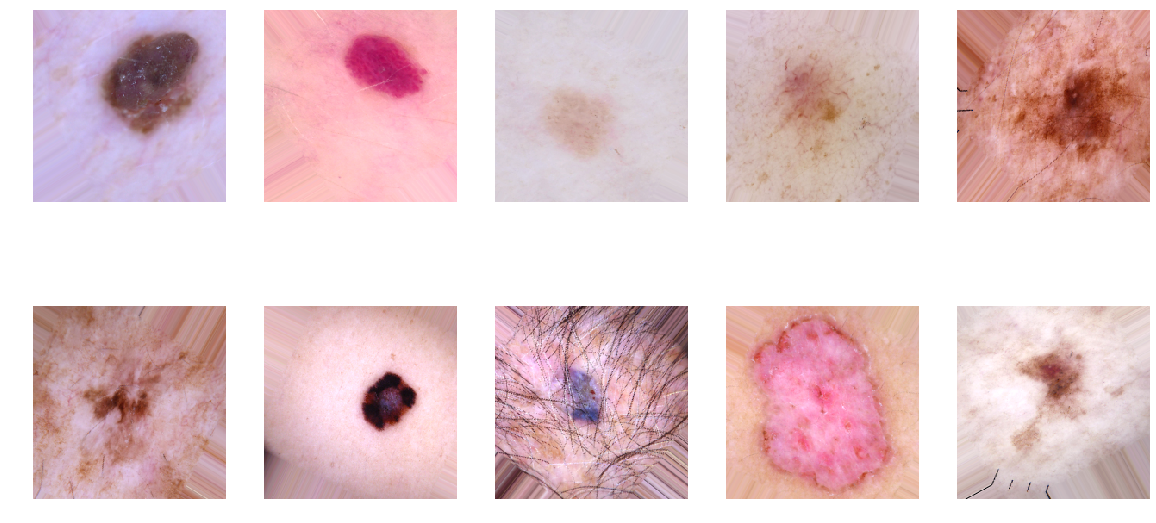

In [23]:
plots(imgs[0:10],titles=None)

## Model

Now we will construct the model using the modular Keras API, which will become the preferred method for building models in Tensorflow 2.0.  Specifically we will create a new model class that subclasses `tf.keras.Model` to incorporate our model design.  This helps with organizing the state of our graph as well as helps make models easier to replicate.

In [0]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import sigmoid, softmax

### Model Definition

In [0]:
#set parameters
num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = num_train_samples // train_batch_size 
val_steps = num_val_samples // val_batch_size

In [26]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.compat.v1.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,classes = ['non-nv','nv'])

valid_batches = datagen.flow_from_directory(val_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,classes = ['non-nv','nv'])

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(val_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 12087 images belonging to 2 classes.
Found 828 images belonging to 2 classes.
Found 828 images belonging to 2 classes.


Our model is going to be of the resnet50.

In [27]:
resnet = ResNet50(include_top=False,weights='imagenet')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


In [0]:
for layer in resnet.layers:
    layer.trainable = False

In [0]:
x=resnet.output
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

x = Dropout(0.25)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='sigmoid')(x) #final layer with softmax activation
model = Model(inputs=resnet.input, outputs=preds)



In [0]:

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [0]:
filepath = "model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                    
    
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


class Metrics(Callback):
  
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
  
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
    val_targ = self.model.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
    return
 
metrics = Metrics()    
    
callbacks_list = [checkpoint, reduce_lr]

In [0]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])


### Training 

In [33]:

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30,
                   callbacks=callbacks_list)

Epoch 1/30
918/918 [==============================] - 133s 145ms/step - loss: 7.7268 - acc: 0.4970 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 2/30
918/918 [==============================] - 124s 136ms/step - loss: 7.7637 - acc: 0.4952 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 3/30
918/918 [==============================] - 126s 137ms/step - loss: 7.6371 - acc: 0.5034 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 4/30
918/918 [==============================] - 125s 136ms/step - loss: 7.6577 - acc: 0.5021 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 5/30
918/918 [==============================] - 124s 135ms/step - loss: 7.7317 - acc: 0.4973 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 6/30
918/918 [==============================] - 124s 135ms/step - loss: 7.5807 - acc: 0.5071 - val_loss: 3.0571 - val_acc: 0.8012
Epoch 7/30
624/918 [===================>..........] - ETA: 34s - loss: 7.8012 - acc: 0.4927

KeyboardInterrupt: ignored

In [0]:
model.save('resnet_transferlearning.h5')

In [0]:
for layer in resnet.layers:
    layer.trainable = True
    
x=resnet.output
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

x = Dropout(0.25)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='sigmoid')(x) #final layer with softmax activation
model_1 = Model(inputs=resnet.input, outputs=preds)



In [0]:
model_1.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
history = model_1.fit_generator(train_batches, steps_per_epoch=train_steps, 
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30,
                   callbacks=callbacks_list)

Epoch 1/30
918/918 [==============================] - 438s 478ms/step - loss: 0.9590 - acc: 0.6103 - val_loss: 0.7465 - val_acc: 0.7835
Epoch 2/30
918/918 [==============================] - 373s 406ms/step - loss: 0.9632 - acc: 0.6068 - val_loss: 0.7327 - val_acc: 0.7866
Epoch 3/30
918/918 [==============================] - 373s 407ms/step - loss: 0.9097 - acc: 0.6144 - val_loss: 0.7216 - val_acc: 0.7854
Epoch 4/30
918/918 [==============================] - 372s 405ms/step - loss: 0.9288 - acc: 0.6165 - val_loss: 0.7670 - val_acc: 0.7866
Epoch 5/30
918/918 [==============================] - 374s 407ms/step - loss: 0.9214 - acc: 0.6187 - val_loss: 0.7628 - val_acc: 0.7866
Epoch 6/30
628/918 [===================>..........] - ETA: 1:52 - loss: 0.8838 - acc: 0.6211

In [0]:
model_1.save('resnet_unfreeze.h5')

No we can finally start to train our model after some final bookkeeping items.

Putting this all together, let's run our training step for several cycles until our model's error converges.

Another helpful tool when training a Tensorflow model is to use Tensorboard to a visualize training progress.  Let's create a directory for our Tensorboard outputs and create a writer.

Another helpful practice is to persist checkpoints of our model every so often.  Tensorflow allows us to save the current model weights, optimizer values as well as the current step.

In [0]:
for layer in resnet.layers:
    layer.trainable = False

## Evaluation

### Score the Model

In [0]:
_ , test_preds = model(test_x)

In [0]:
THRESHOLD = 0.4
test_class = np.where(test_preds.numpy() > THRESHOLD, 1, 0)

In [0]:
import sklearn
display(sklearn.metrics.classification_report(test_y,test_class, output_dict=True))

{'0.0': {'precision': 0.7868852459016393,
  'recall': 0.7700534759358288,
  'f1-score': 0.7783783783783783,
  'support': 187},
 '1.0': {'precision': 0.9430463576158941,
  'recall': 0.948069241011984,
  'f1-score': 0.9455511288180611,
  'support': 751},
 'micro avg': {'precision': 0.9125799573560768,
  'recall': 0.9125799573560768,
  'f1-score': 0.9125799573560768,
  'support': 938},
 'macro avg': {'precision': 0.8649658017587667,
  'recall': 0.8590613584739064,
  'f1-score': 0.8619647535982198,
  'support': 938},
 'weighted avg': {'precision': 0.9119140251099606,
  'recall': 0.9125799573560768,
  'f1-score': 0.9122235122591904,
  'support': 938}}

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function 
    s and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    FROM: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


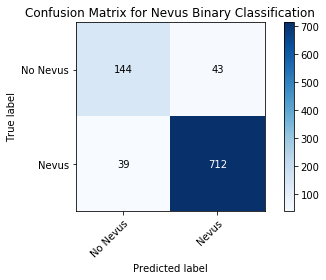

In [0]:
plot_confusion_matrix(test_y,test_class,['No Nevus','Nevus'],title='Confusion Matrix for Nevus Binary Classification')

### Inspect Predictions

In [0]:
wrong_mask = (test_y != test_class).reshape(-1)
wrong_labels = test_data['labels'][wrong_mask]
wrong_preds = test_class[wrong_mask]
wrong_images = test_x[wrong_mask]

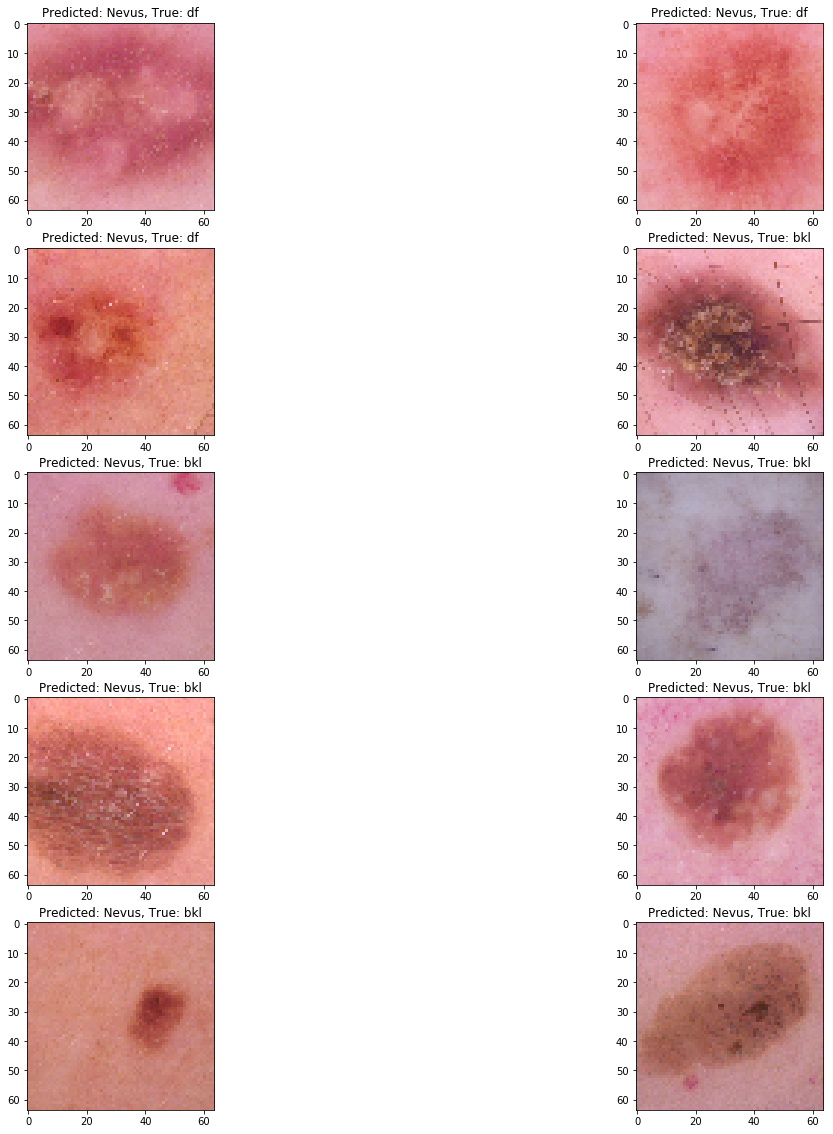

In [0]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (label, pred, image_std) in enumerate(zip(wrong_labels[:10],wrong_preds[:10],wrong_images[:10])):
    label_txt = class_names[label]
    pred_txt = 'No Nevus' if pred == 0 else 'Nevus'
    original_image = (image_std * channel_std +  channel_mean).astype(np.uint8)
    ax[i//2,i%2].title.set_text('Predicted: %s, True: %s' % (pred_txt, label_txt))
    ax[i//2,i%2].imshow(original_image)

### Inspect feature vector

In [0]:
test_features = model.features(test_x)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
test_features_2d = pca.fit(test_features).transform(test_features)

In [0]:
nevus_mask, no_nevus_mask = (test_y == 1).reshape(-1), (test_y == 0).reshape(-1)

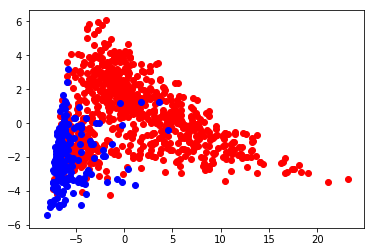

In [0]:
plt.scatter(test_features_2d[nevus_mask,0],test_features_2d[nevus_mask,1],color='r')
plt.scatter(test_features_2d[no_nevus_mask,0],test_features_2d[no_nevus_mask,1], color='b')